## Detectron Faster RCNN

This notebook only contains the visualization and prediction for the faster RCNN on the VG. It can mainly be seen as a demo of it's capabilities and is not closely related to the SOLaCE framework. Run ``detectron2/train_faster_rcnn.py`` to train the actual model.
Tested with detectron=0.4.1, torch=1.7.1, python=3.7.10, cuda=11.0


Use the faster RCNN implementation from detectron2.

In [1]:
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt

## Import the VG dataset

Download the data files for the VG (https://visualgenome.org/api/v0/api_home.html) and change the path to where they were stored.

In [2]:
vg_path = "/ssd/tobias/datasets/vg"

In [3]:
import visual_genome.local as vg # Install the VG API from https://github.com/ranjaykrishna/visual_genome_python_driver
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image as PIL_Image
# Uncomment for preprocessing
#vg.add_attrs_to_scene_graphs(data_dir=vg_path)
#vg.save_scene_graphs_by_id(data_dir=vg_path, image_data_dir=vg_path+'/by-id')

In [4]:
im_list = vg.get_all_image_data(data_dir=vg_path) # image metadata
id_dict = {}

In [5]:
# Show metadata for a sample images
print(im_list[23])

id: 24, coco_id: -1, flickr_id: -1, width: 800, url: https://cs.stanford.edu/people/rak248/VG_100K/24.jpg


In [6]:
imggraph = vg.get_scene_graph(24, images=vg_path, image_data_dir=vg_path + '/by-id/', synset_file=vg_path+'/synsets.json')

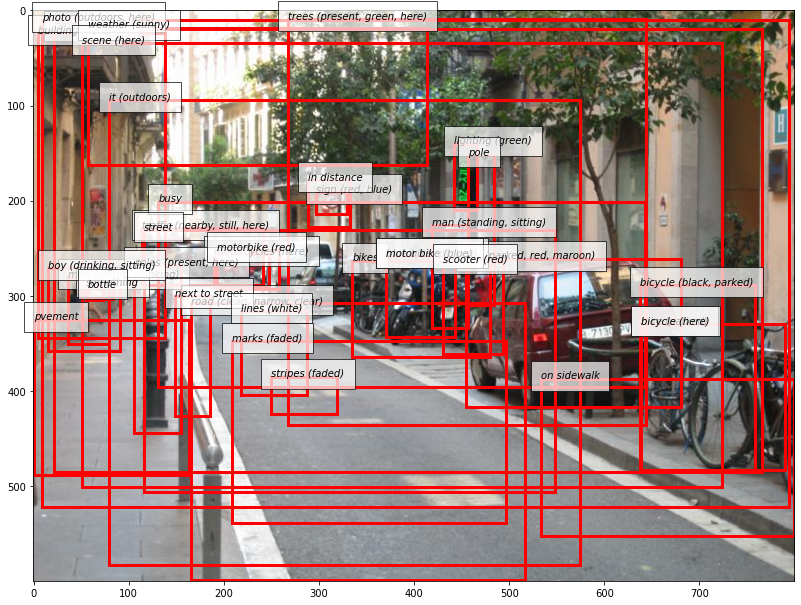

In [7]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
data_path = '/ssd/tobias/datasets/vg/'
striplen = len("https://cs.stanford.edu/people/rak248/") # remove from image location
def visualize_regions(graph):
    img = PIL_Image.open(data_path + graph.image.url[striplen:])
    plt.imshow(img)
    ax = plt.gca()
    for my_obj in graph.objects:
        ax.add_patch(Rectangle((my_obj.x, my_obj.y),
                               my_obj.width,
                               my_obj.height,
                               fill=False,
                               edgecolor='red',
                               linewidth=3))
        # find corresponding attributes
        myoid = my_obj.id
        att_list = []
        for a in graph.attributes:
            if a.subject.id == myoid:
                att_list += [satt.strip(" ") for satt in a.attribute]
        
        myatts = ", ".join(att_list)
        if len(att_list) > 0:
            ax.text(my_obj.x, my_obj.y, my_obj.names[0] + " (" + myatts + ")" , style='italic', bbox={'facecolor':'white', 'alpha':0.7, 'pad':10})
        else:
            ax.text(my_obj.x, my_obj.y, my_obj.names[0], style='italic', bbox={'facecolor':'white', 'alpha':0.7, 'pad':10})
        
    fig = plt.gcf()
    plt.tick_params(labelbottom='off', labelleft='off')
    plt.show()
visualize_regions(imggraph)

## Load the preprocessed datasets and Register for Detectron

Make sure you have downloaded the corresponding files from [https://visualgenome.org/api/v0/api_home.html] in the following ``vg_path`` folder.

In [8]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

import os, sys
sys.path.append("detectron2")
from AttributeROIHead import *

%load_ext autoreload
%autoreload 2

In [9]:
def get_vg_dicts_cached(vg_dir, val=False):
    " Load the preprocessed dictionaries for the VG dataset."
    fname = vg_dir + "detectron_" + ("val" if val else "train") + "_filtered.json"
    fhandle = open(fname)
    data = json.load(fhandle)
    fhandle.close()
    return data

In [10]:
appearing_objects = json.load(open("data/json/appearing_objects_filtered.json"))
appearing_attributes = json.load(open("data/json/appearing_attributes_filtered.json"))
for d in ["train", "val"]:
    DatasetCatalog.register("vg_" + d, lambda d=d: get_vg_dicts_cached(data_path, d == "val"))
    MetadataCatalog.get("vg_" + d).set(thing_classes=list(appearing_objects.values()))
    MetadataCatalog.get("vg_" + d).set(attribute_classes=list(appearing_attributes.values()))
vg_metadata = MetadataCatalog.get("vg_val")

# Show some examples from the dataset

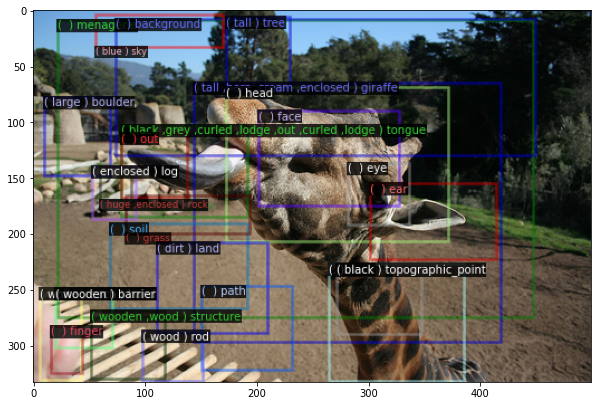

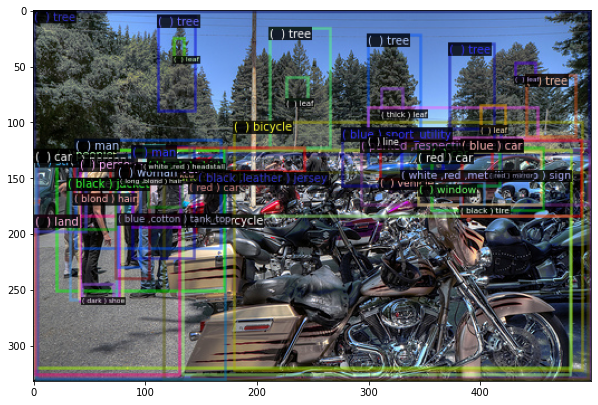

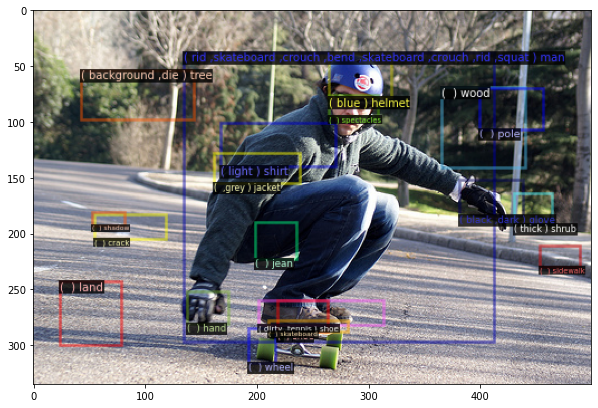

In [11]:
mydataset = get_vg_dicts_cached(vg_path+"/", val=False)
for d in random.sample(mydataset, 3):
    img = cv2.imread(d["file_name"])
    #print(d)
    visualizer = VisualizerWAttributes(img[:, :, ::-1], metadata=vg_metadata, scale=1.0)
    out = visualizer.draw_dataset_dict(d)
    im_rgb = cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB)
    plt.imshow(im_rgb)
    plt.gcf().set_size_inches(10,10)
    plt.show()

# Predict with the model

Load the checkpoint an run the FRCNN. Show some sample outputs.

In [12]:
import sys
#sys.path.append("../detectron2")
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

from AttributeROIHead import *

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("vg_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 4

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 20000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate

cfg.MODEL.DEVICE= "cuda:0"
cfg.MODEL.ROI_HEADS.NAME = "AttributeROIHead"
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3434  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
cfg.MODEL.ROI_HEADS.NUM_ATTRIBUTES = 2979  # number of attributes in trainingset
cfg.MODEL.ROI_BOX_HEAD.FC_DIM = 3072
cfg.OUTPUT_DIR = "../output"
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.
cfg.MODEL.WEIGHTS = os.path.join("output/frcnn_model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3   # set a custom testing threshold!

predictor = DefaultPredictor(cfg)
#trainer = DefaultTrainer(cfg) 
#trainer.resume_or_load(resume=False)
#trainer.train()

Initialized FastRCNNOutputLayerWithAttributes with 2979 attributes.
[04/06 09:22:38 d2.engine.defaults]: Modified default predictor


## Predict some examples from the test set (skip if not interested)

/home/dsar/Documents/Tobias/solace-concepts/AttributeROIHead.py:595: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  filter_inds = filter_mask.nonzero() # indices where class score is larger than threshold [id first clm, class second clm]


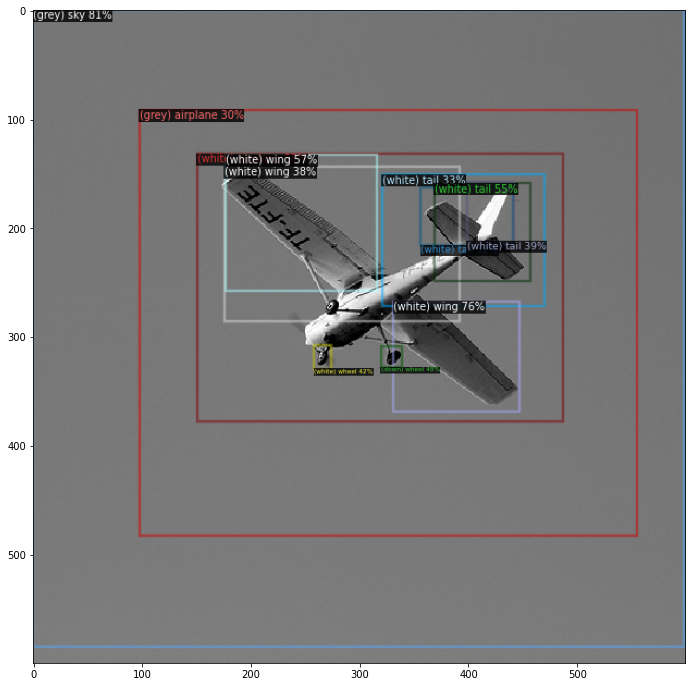

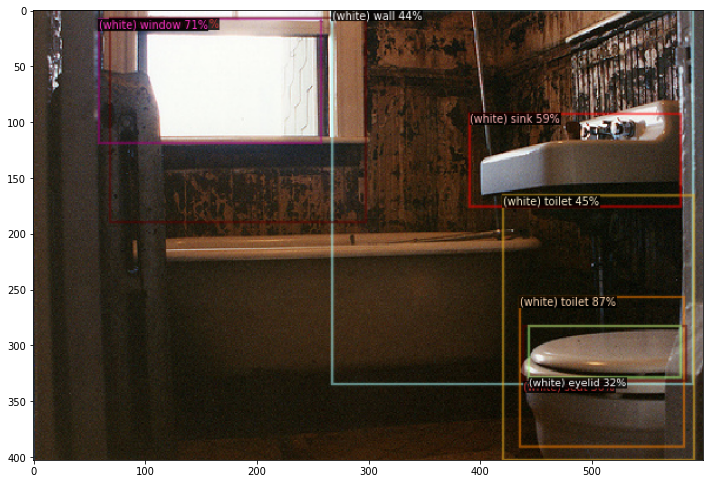

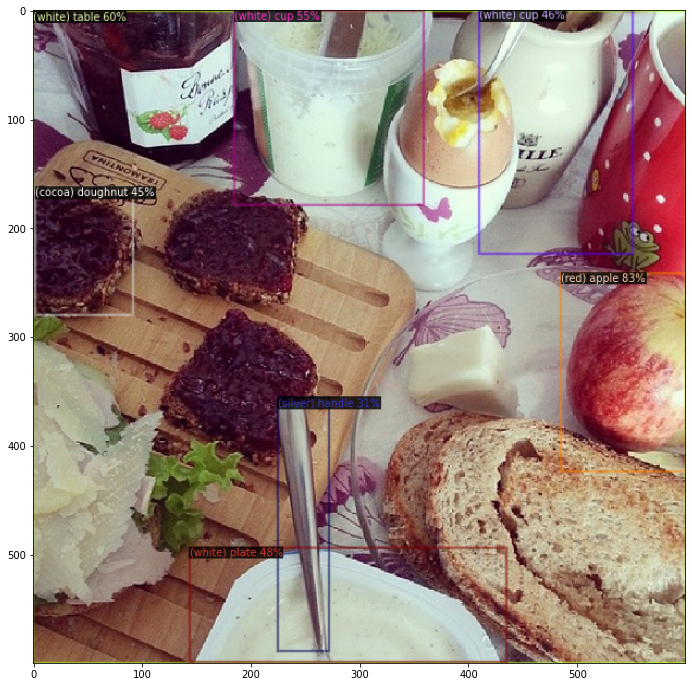

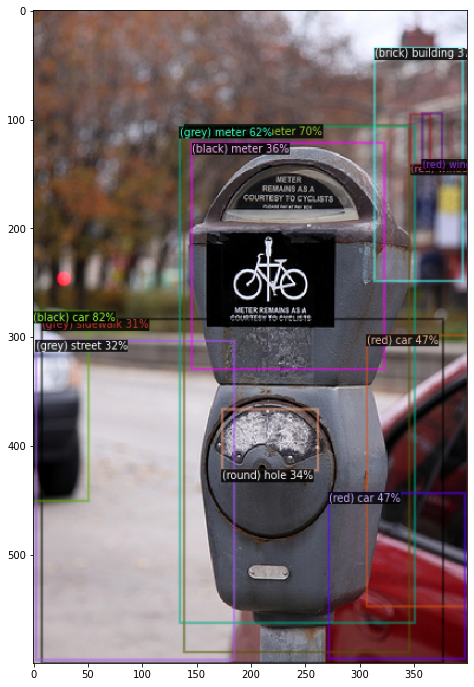

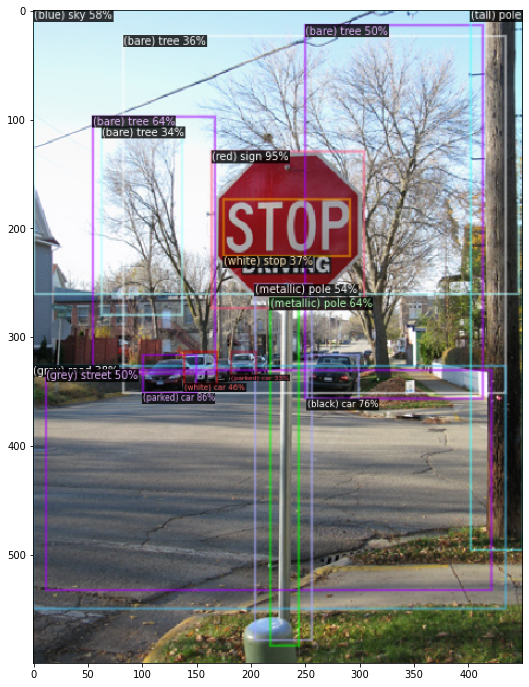

In [15]:
from detectron2.utils.visualizer import ColorMode
import torch
dataset_dicts = get_vg_dicts_cached(vg_path +"/", True)
idx = 13
for d in random.sample(dataset_dicts, 5):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = VisualizerWAttributes(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image())
    plt.gcf().set_size_inches(12, 12)
    #plt.savefig(f"../mmf/output/predict_{idx}", dpi=500)
    plt.show()
    idx +=1